# Notebook Imports / Config

In [1]:
from datetime import datetime
import os
import sys

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from tqdm import tqdm_notebook

%load_ext line_profiler
%load_ext Cython
%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# SparseHC-Inspired Clustering Method

In [ ]:
from bisect import insort

from blist import blist
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances


class LinearAC(object):
    def __init__(self, obs_matrix, verbose=False):
        self.obs_matrix = obs_matrix
        self.verbose = verbose
        self.total_obs = len(obs_matrix)
        self.ascending_obs_dists = None
        self.total_clusters = None
        self.magnitudes = None
        self.obs_current_clusters = None
        self.parents = None
        self.children = None
        self.descendent_obs = None
        self.candidate_connections = None
        self.next_cluster_id = None
        self.max_obs_pair_dist = None
        self.complete_queue = None
    
    
    def fit(self, final_clusters=1):
        self.total_clusters = self.total_obs*2-final_clusters
        self.magnitudes = np.ones(self.total_clusters)
        self.magnitudes[self.total_obs:] = -1
        self.obs_current_clusters = np.arange(0, self.total_obs)
        self.parents = np.full(self.total_clusters, -1)
        self.children = np.full((self.total_clusters, 2), -1)
        self.descendent_obs = {}
        for i in np.arange(0, self.total_obs):
            self.descendent_obs[i] = [i]
        self.candidate_connections = {}
        for i in np.arange(0, self.total_clusters):
            self.candidate_connections[i] = {}
        
        # initialize distances data with which to cluster observations
        optimal_rdmmm = min(
            4.02-0.00259*self.total_obs+0.00000116*self.total_obs**2,
            # https://docs.google.com/spreadsheets/d/1f--k4fmyTh5dv_geg3WKZV2yBsFzD6TDO2fGbEpNp9o/edit#gid=0
            500.0
        )
        self.ascending_obs_dists = get_partial_sorted_distance_matrix(
            self.obs_matrix,
            return_dist_matrix_max_mb=optimal_rdmmm
        )
        
        self.next_cluster_id = self.total_obs * 1
        self.max_obs_pair_dist = -np.inf
        self.complete_queue = blist()
        iterations = 1
        while self.next_cluster_id < self.total_clusters:
            min_incomplete_dist = np.inf
            if self.verbose:
                print('Iteration %d \n%d Clusters \n%d New Obs \nCQ Len %d' 
                      % (iterations, self.next_cluster_id, 
                         len(self.ascending_obs_dists), len(self.complete_queue)))
            # parse through sorted observation distances to evaluate potential cluster pairings
            for obs_tuple in self.ascending_obs_dists:
                obs_pair_dist = obs_tuple[0]
                obs_0 = int(obs_tuple[1])
                obs_1 = int(obs_tuple[2])
                self.max_obs_pair_dist = max(self.max_obs_pair_dist, obs_pair_dist)
                cluster_0 = self.obs_current_clusters[obs_0]
                cluster_1 = self.obs_current_clusters[obs_1]
                if cluster_0 != cluster_1:
                    # update candidate connection linkages to account for obs-pair information
                    is_complete, lb_avg_dist = (
                        self._update_candidate_connections(cluster_0, cluster_1, obs_pair_dist)
                    )
                    if is_complete:
                        self.complete_queue.append((lb_avg_dist, cluster_0, cluster_1))
            for candidates in self.candidate_connections.values():
                for connection in candidates.values():
                    if not connection['is_complete']:
                        min_incomplete_dist = min(min_incomplete_dist, connection['lb_avg_dist'])
            # convert completed potential clusters to actual ones
            while ((self.next_cluster_id < self.total_clusters)
                   and (len(self.complete_queue) > 0)
                   and (self.complete_queue[0][0] <= min_incomplete_dist)):
                cluster_tuple = self.complete_queue.pop(0)
                avg_dist = cluster_tuple[0]
                cluster_0 = cluster_tuple[1]
                cluster_1 = cluster_tuple[2]
                if ((self.parents[cluster_0] == -1) and (self.parents[cluster_1] == -1)):
                    self._merge_clusters(cluster_0, cluster_1)
                    self.next_cluster_id +=1
            if ((self.next_cluster_id < self.total_clusters)
                and len(self.ascending_obs_dists)>0):
                self.ascending_obs_dists = get_partial_sorted_distance_matrix(
                    self.obs_matrix,
                    return_dist_matrix_max_mb=optimal_rdmmm,
                    prior_final_dist=self.ascending_obs_dists[-1, 0]
                )
            iterations += 1
            
    
    def _update_candidate_connections(self, cluster_0, cluster_1, sum_dists, n_dists=1):
        # if candidate connection already exists between clusters, update it
        if cluster_1 in self.candidate_connections[cluster_0]:
            candidate_connection = self.candidate_connections[cluster_0][cluster_1]
            candidate_connection['sum_dists'] += sum_dists
            candidate_connection['n_dists'] += n_dists
            candidate_connection['is_complete'] = (
                candidate_connection['n_dists'] == candidate_connection['complete_dists']
            )
            with cython.cdivision(True):
                candidate_connection['lb_avg_dist'] = (
                    (candidate_connection['sum_dists']
                     + self.max_obs_pair_dist
                     * (candidate_connection['complete_dists'] - candidate_connection['n_dists']))
                    / candidate_connection['complete_dists']
            )
        # otherwise create a new connection
        else:
            candidate_connection = {}
            candidate_connection['sum_dists'] = sum_dists
            candidate_connection['n_dists'] = n_dists
            candidate_connection['complete_dists'] = self.magnitudes[cluster_0] * self.magnitudes[cluster_1]
            candidate_connection['is_complete'] = (
                candidate_connection['n_dists'] == candidate_connection['complete_dists']
            )
            with cython.cdivision(True):
                candidate_connection['lb_avg_dist'] = (
                    (candidate_connection['sum_dists']
                     + self.max_obs_pair_dist
                     * (candidate_connection['complete_dists'] - candidate_connection['n_dists']))
                    / candidate_connection['complete_dists']
                )

        self.candidate_connections[cluster_0][cluster_1] = candidate_connection
        self.candidate_connections[cluster_1][cluster_0] = candidate_connection

        return candidate_connection['is_complete'], candidate_connection['lb_avg_dist']
    
    
    def _merge_clusters(self, cluster_0, cluster_1):
        #merge magnitudes
        next_cluster_magnitude = self.magnitudes[cluster_0] + self.magnitudes[cluster_1]
        self.magnitudes[self.next_cluster_id] = next_cluster_magnitude

        # merge descendent observations
        next_cluster_descendent_obs = self.descendent_obs[cluster_0] + self.descendent_obs[cluster_1]
        self.descendent_obs[self.next_cluster_id] = next_cluster_descendent_obs

        # redirect descendent observation clusters
        for obs in next_cluster_descendent_obs:
            self.obs_current_clusters[obs] = self.next_cluster_id 

        # redirect parents
        self.parents[cluster_0] = self.next_cluster_id
        self.parents[cluster_1] = self.next_cluster_id

        # redirect children
        self.children[self.next_cluster_id, :] = (cluster_0, cluster_1)

        # rewire merged-clusters candidate connections toward new cluster
        cc_0 = self.candidate_connections[cluster_0]
        cc_1 = self.candidate_connections[cluster_1]
        candidate_clusters = (cc_0.keys() | cc_1.keys()) - set([cluster_0, cluster_1])
        for cluster in candidate_clusters:
            sum_dists = 0
            n_dists = 0
            if cluster in cc_0.keys():
                sum_dists += cc_0[cluster]['sum_dists']
                n_dists += cc_0[cluster]['n_dists']
                del self.candidate_connections[cluster][cluster_0]
            if cluster in cc_1.keys():
                sum_dists += cc_1[cluster]['sum_dists']
                n_dists += cc_1[cluster]['n_dists']
                del self.candidate_connections[cluster][cluster_1]
            is_complete, lb_avg_dist = (
                self._update_candidate_connections(cluster, self.next_cluster_id, sum_dists,
                                                   n_dists=n_dists)
            )
            if is_complete:
                new_cluster_tuple = (lb_avg_dist, cluster, self.next_cluster_id)
                insort(self.complete_queue, new_cluster_tuple)
        del self.candidate_connections[cluster_0]
        del self.candidate_connections[cluster_1]
        

def get_partial_sorted_distance_matrix(obs_matrix, prior_final_dist=None, slice_dist_matrix_max_mb=500.0, 
                                       return_dist_matrix_max_mb=500.0):
    """
    Note: this can fail if pairs_to_return is less than the number of observation pairs
    with some equal distance.
    """
    # configure slicing
    total_obs = len(obs_matrix)
    slice_dist_matrix_elements = int(
        (slice_dist_matrix_max_mb - 1.12e-4 * 2) # account for array overhead, accounting for long form matrix
         / (8e-6 * 4) # 8 bytes per element, accounting for long form matrix
    )
    rows_per_slice = int(slice_dist_matrix_elements / total_obs)

    # configure output
    pairs_to_return = int(min(
        (return_dist_matrix_max_mb - 1.12e-4) # account for array overhead
            / (8e-6 * 3), # 24 bytes per element including indexes
        (total_obs**2 - total_obs)/2 # upper bound = distinct pairs
    ))
    partial_sorted_dist_matrix = np.full((pairs_to_return*2, 3), np.inf)

    # slice through observations and record pairs_to_return smallest-distance pairs
    for slice_start in range(0, total_obs, rows_per_slice):
        # generate pair distances for slice
        slice_end = min(slice_start + rows_per_slice, total_obs)
        slice_dist_matrix = euclidean_distances(obs_matrix[slice_start:slice_end], obs_matrix)
        slice_dist_matrix_len = (slice_end-slice_start)
        
        slice_dist_matrix_long_len = (
            sum(range(total_obs - slice_start - 1, total_obs - slice_end - 1, -1))
        )
        slice_dist_matrix_long = np.full((slice_dist_matrix_long_len, 3), np.inf)

        # transform distances matrix to long form with no dupes
        insertion_start = 0
        insertion_end = 0
        for i in range(0, slice_dist_matrix_len):
            insertion_end += (total_obs - (i+slice_start+1))
            np.copyto(slice_dist_matrix_long[insertion_start:insertion_end, 0],
                      slice_dist_matrix[i, i+slice_start+1:]
            )
            np.copyto(slice_dist_matrix_long[insertion_start:insertion_end, 1],
                      i+slice_start
            )
            np.copyto(slice_dist_matrix_long[insertion_start:insertion_end, 2],
                      np.arange(i+slice_start+1, total_obs)
            )
            insertion_start = insertion_end

        # determine best local candidates and merge into global set
        slice_pairs_to_return = min(pairs_to_return, insertion_end)
        # force already-extracted pairs to the back of the queue
        if prior_final_dist is not None:
            slice_dist_matrix_long[slice_dist_matrix_long[:, 0] <= prior_final_dist] = np.inf
        # get closest slice pairs by dist, combine slice matrix w/ global matrix
        np.copyto(partial_sorted_dist_matrix[pairs_to_return:(pairs_to_return+slice_pairs_to_return)],
                  slice_dist_matrix_long[
                      np.argpartition(slice_dist_matrix_long[:, 0], slice_pairs_to_return-1)
                  ][:slice_pairs_to_return]
        )
        # get closes pairs by dist out of the merged matrix
        np.copyto(partial_sorted_dist_matrix,
                  partial_sorted_dist_matrix[
                      np.argpartition(partial_sorted_dist_matrix[:, 0], pairs_to_return-1)
                  ]
        )
        np.copyto(partial_sorted_dist_matrix[pairs_to_return:],
                  np.inf
        )

    # final processing
    #trim 
    partial_sorted_dist_matrix = partial_sorted_dist_matrix[:pairs_to_return]
    # drop infs
    partial_sorted_dist_matrix = partial_sorted_dist_matrix[partial_sorted_dist_matrix[:, 0]<np.inf]
    # sort
    np.copyto(partial_sorted_dist_matrix,
              partial_sorted_dist_matrix[
                  np.argsort(partial_sorted_dist_matrix[:, 0])
              ]
    )
#     # ensure no pairs of equal distance will be split between this return and another
#     partial_sorted_dist_matrix = partial_sorted_dist_matrix[
#         partial_sorted_dist_matrix[:, 0]<partial_sorted_dist_matrix[-1, 0]
#     ]
    return partial_sorted_dist_matrix

## Proof of Concept

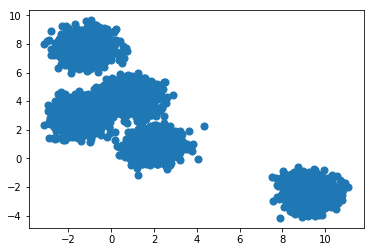

In [9]:
size=5000
X, y_true = make_blobs(n_samples=size, centers=5,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [10]:
%%time
test_linear_ac = LinearAC(X)
test_linear_ac.fit()

CPU times: user 1min 50s, sys: 8.14 s, total: 1min 58s
Wall time: 1min 58s


250 clusters


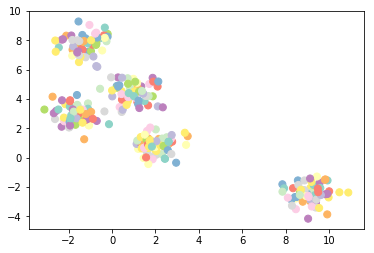

100 clusters


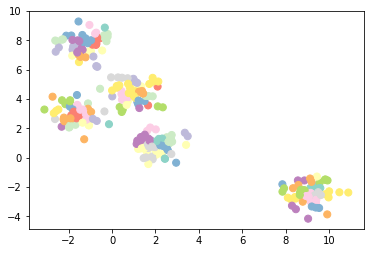

50 clusters


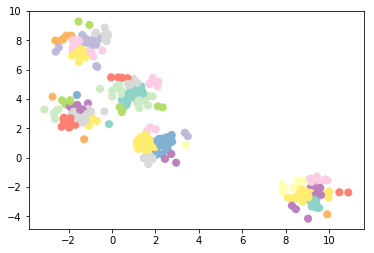

25 clusters


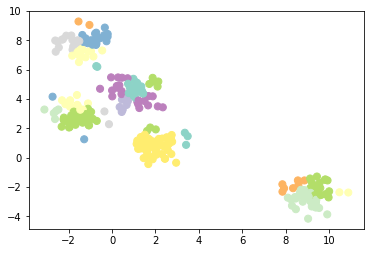

10 clusters


5 clusters


2 clusters


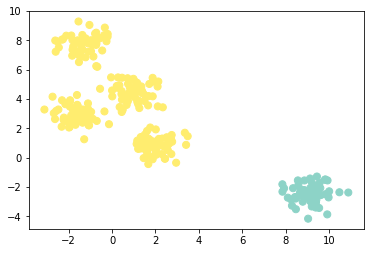

1 clusters


In [5]:
cluster_obs = {}
for i in np.arange(0, size):
    cluster_obs[i] = [i]

cluster_labels = np.arange(0, size)

cluster_id = size * 1 

for children in test_linear_ac.children:
    child_0 = children[0]
    child_1 = children[1]
    if((child_0 == -1) or (child_1 == -1)):
        continue

    cluster_obs[cluster_id] = cluster_obs[child_0] + cluster_obs[child_1]
    del cluster_obs[child_0]
    del cluster_obs[child_1]

    for obs in cluster_obs[cluster_id]:
        cluster_labels[obs] = cluster_id
        
    if len(cluster_obs) in [250, 100, 50, 25, 10, 5, 2, 1]:
        print('%d clusters' % (len(cluster_obs)))
        plt.scatter(X[:, 0], X[:, 1], s=50, cmap=plt.cm.Set3, c=cluster_labels%25)
        plt.show()
        plt.close()
    
    cluster_id += 1

## Parameter Experimentation

Tracker: https://docs.google.com/spreadsheets/d/1f--k4fmyTh5dv_geg3WKZV2yBsFzD6TDO2fGbEpNp9o/edit#gid=0

More slice matrix ram = strictly faster runs

In [16]:
size=1250
rdmm_mbs = [1.25, 2.5, 3.75]
sdmm_mbs = [500.0]

for rdmm in rdmm_mbs:
    for sdmm in sdmm_mbs:
        X, y_true = make_blobs(n_samples=size, centers=5,
                               cluster_std=0.60, random_state=0)
        start = datetime.utcnow()
        clusters = linear_ac(
            X, 
            slice_dist_matrix_max_mb=sdmm,
            return_dist_matrix_max_mb=rdmm
        )
        finish = datetime.utcnow()
        print('\n Return DMM: %d \nSlice DMM: %d \n Minutes: %s' %
              (rdmm, sdmm, (finish - start).seconds/60.0))


 Return DMM: 1 
Slice DMM: 500 
 Minutes: 0.13333333333333333

 Return DMM: 2 
Slice DMM: 500 
 Minutes: 0.13333333333333333

 Return DMM: 3 
Slice DMM: 500 
 Minutes: 0.15


In [15]:
size=2500
rdmm_mbs = [2.5, 5.0, 7.5, 10]
sdmm_mbs = [500.0]

for rdmm in rdmm_mbs:
    for sdmm in sdmm_mbs:
        X, y_true = make_blobs(n_samples=size, centers=5,
                               cluster_std=0.60, random_state=0)
        start = datetime.utcnow()
        clusters = linear_ac(
            X, 
            slice_dist_matrix_max_mb=sdmm,
            return_dist_matrix_max_mb=rdmm
        )
        finish = datetime.utcnow()
        print('\n Return DMM: %d \nSlice DMM: %d \n Minutes: %s' %
              (rdmm, sdmm, (finish - start).seconds/60.0))


 Return DMM: 2 
Slice DMM: 500 
 Minutes: 0.5

 Return DMM: 5 
Slice DMM: 500 
 Minutes: 0.48333333333333334

 Return DMM: 7 
Slice DMM: 500 
 Minutes: 0.5

 Return DMM: 10 
Slice DMM: 500 
 Minutes: 0.55


In [12]:
size=5000
rdmm_mbs = [10.0, 15.0, 20.0, 25.0, 30.0]
sdmm_mbs = [500.0]

for rdmm in rdmm_mbs:
    for sdmm in sdmm_mbs:
        X, y_true = make_blobs(n_samples=size, centers=5,
                               cluster_std=0.60, random_state=0)
        start = datetime.utcnow()
        clusters = linear_ac(
            X, 
            slice_dist_matrix_max_mb=sdmm,
            return_dist_matrix_max_mb=rdmm
        )
        finish = datetime.utcnow()
        print('\n Return DMM: %d \nSlice DMM: %d \n Minutes: %s' %
              (rdmm, sdmm, (finish - start).seconds/60.0))


 Return DMM: 10 
Slice DMM: 500 
 Minutes: 2.4166666666666665

 Return DMM: 15 
Slice DMM: 500 
 Minutes: 2.2

 Return DMM: 20 
Slice DMM: 500 
 Minutes: 2.183333333333333

 Return DMM: 25 
Slice DMM: 500 
 Minutes: 2.216666666666667

 Return DMM: 30 
Slice DMM: 500 
 Minutes: 2.466666666666667


KeyboardInterrupt: 

In [21]:
size=7500
rdmm_mbs = [30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]
sdmm_mbs = [500.0]

for rdmm in rdmm_mbs:
    for sdmm in sdmm_mbs:
        X, y_true = make_blobs(n_samples=size, centers=5,
                               cluster_std=0.60, random_state=0)
        start = datetime.utcnow()
        clusters = linear_ac(
            X, 
            slice_dist_matrix_max_mb=sdmm,
            return_dist_matrix_max_mb=rdmm
        )
        finish = datetime.utcnow()
        print('\n Return DMM: %d \nSlice DMM: %d \n Minutes: %s' %
              (rdmm, sdmm, (finish - start).seconds/60.0))


 Return DMM: 30 
Slice DMM: 500 
 Minutes: 5.316666666666666

 Return DMM: 40 
Slice DMM: 500 
 Minutes: 5.6

 Return DMM: 50 
Slice DMM: 500 
 Minutes: 5.183333333333334

 Return DMM: 60 
Slice DMM: 500 
 Minutes: 5.333333333333333

 Return DMM: 70 
Slice DMM: 500 
 Minutes: 5.533333333333333

 Return DMM: 80 
Slice DMM: 500 
 Minutes: 5.833333333333333

 Return DMM: 90 
Slice DMM: 500 
 Minutes: 5.95
